YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


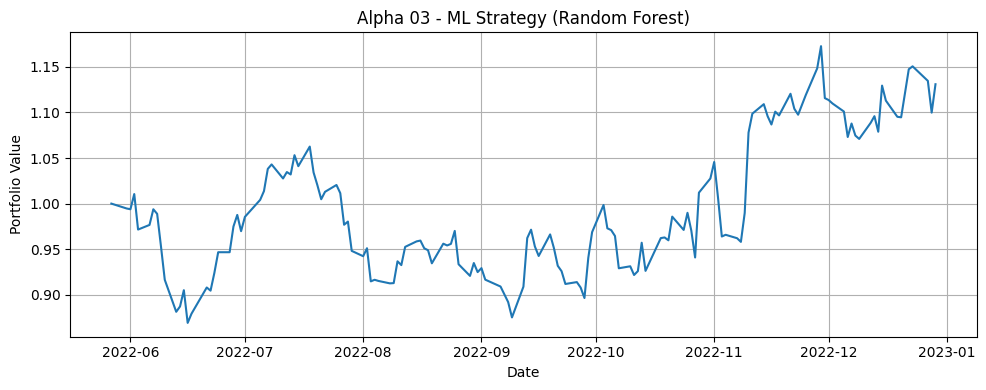

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys, os


def backtest_strategy(returns, positions):
    strategy_returns = returns * positions.shift(1)  # use previous day's signal
    strategy_returns = strategy_returns.fillna(0)
    cumulative = (1 + strategy_returns).cumprod()
    return cumulative

def get_stock_data(ticker, start='2020-01-01', end='2023-01-01'):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].copy()
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] / df['Close'].shift(10) - 1
    df['Future_Return'] = df['Return'].shift(-1)
    df.dropna(inplace=True)
    return df

def generate_features_targets(df):
    X = df[['Return', 'Volatility', 'Momentum']].values
    y = df['Future_Return'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, shuffle=False), scaler

def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def predict_positions(df, model, scaler):
    X = df[['Return', 'Volatility', 'Momentum']].values
    X_scaled = scaler.transform(X)
    df['Predicted_Return'] = model.predict(X_scaled)
    df['Position'] = np.sign(df['Predicted_Return'])  # +1 or -1
    return df

def run():
    df = get_stock_data('AAPL')
    (X_train, X_test, y_train, y_test), scaler = generate_features_targets(df)
    model = train_model(X_train, y_train)
    df = df.iloc[-len(X_test):]  # align with test period
    df = predict_positions(df, model, scaler)

    portfolio = backtest_strategy(df['Return'], df['Position'])
    
    plt.figure(figsize=(10, 4))
    plt.plot(portfolio.index, portfolio.values)
    plt.title("Alpha 03 - ML Strategy (Random Forest)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run()
